# Regression of Used Car Prices

In [216]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
from catboost import cv
from catboost import Pool


In [217]:
data = pd.read_csv('train.csv')
data.head()


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [218]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


Рассмотрим столбцы:
1. id - совпадает с индексом нашей строки
2. brand - марка автомобиля
3. model - модель автомобиля
4. model_year - год выпуска
5. milage - пробег
6. fuel_type - тип топлива
7. engine - двигатель(мощность + объём + кол-во цилиндров + тип двигателя + тип топлива)
8. transmission - тип коробки передач
9. ext_col - цвет автомобиля
10. int_col - цвет салона
11. accident - информация о ДТП
12. clean_title - статус юридической чистоты автомобиля 
13. price - цена автомобиля

# Exploratiry Data Analysis

In [219]:
# Удалим столбец id
data = data.drop(columns = ['id'])
data.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [220]:
# Создадим список категориальных фичей
categorical_columns = data.select_dtypes(include=['object']).columns.to_list()
# Создадим список числовых фичей
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.difference(['price','id']).to_list()
# Создадим target с ценами автомобилей
target = 'price'

print("Categorical_columns:")
print(categorical_columns)
print("Numerical_columns:")
print(numerical_columns)

print()

Categorical_columns:
['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Numerical_columns:
['milage', 'model_year']



## Brand

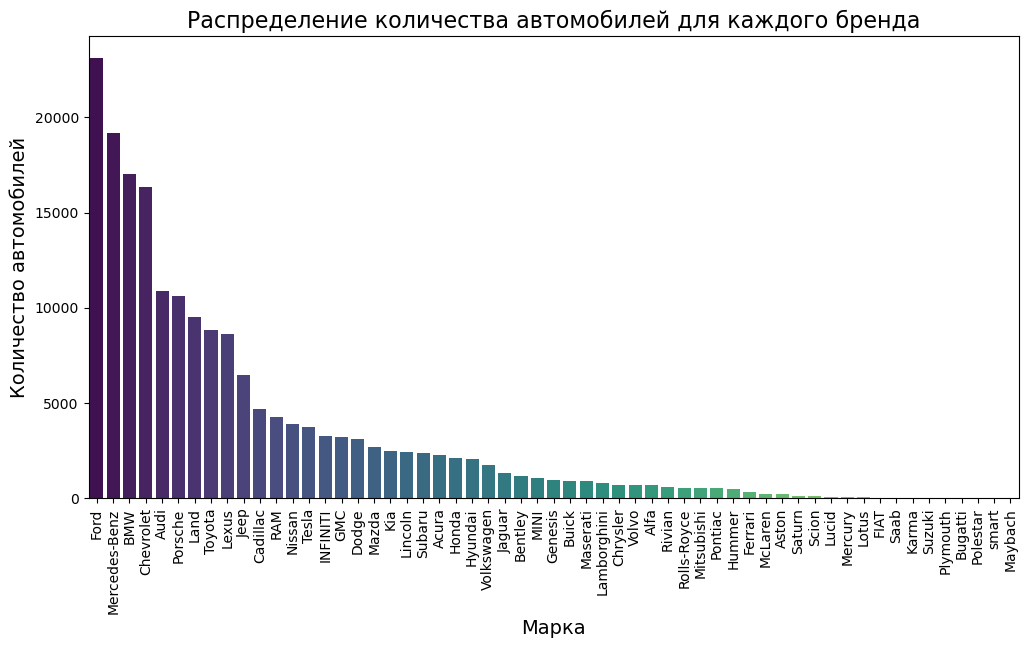

In [221]:
# Подсчёт количества автомобилей для каждого бренда
brand_counts = data['brand'].value_counts()

# Увеличиваем размер графика для лучшей видимости
plt.figure(figsize=(12, 6))

# Построение столбчатой диаграммы
sns.barplot(x=brand_counts.index, y=brand_counts.values, palette='viridis')

# Добавление подписей
plt.title('Распределение количества автомобилей для каждого бренда', fontsize=16)
plt.xlabel('Марка', fontsize=14)
plt.ylabel('Количество автомобилей', fontsize=14)
plt.xticks(rotation=90)  # Поворачиваем подписи брендов для лучшего отображения

# Отображение графика
plt.show()


У нас есть 57 различных брендов автомобилей.

In [222]:
print("Количество продаж топ-10 самых популярных марок:")
print(brand_counts[:10])

Количество продаж топ-10 самых популярных марок:
brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Name: count, dtype: int64


In [223]:
print("Количество продаж топ-10 самых популярных марок:")
print(brand_counts[-10:])

Количество продаж топ-10 самых популярных марок:
brand
Lotus       52
FIAT        44
Saab        22
Karma       17
Suzuki       8
Plymouth     7
Bugatti      7
Polestar     7
smart        3
Maybach      3
Name: count, dtype: int64


Проблема: На 10 элементах определённой марки модель может не научится адекватно строить прогнозы.

## Model

In [224]:
model_counts = data['model'].value_counts()
print(len(model_counts))

1897


Датасет содержит 1897 различных моделей автомобилей

In [225]:
print("Топ 10 самых популярный моделей автомобилей:")
print(model_counts[:10])

Топ 10 самых популярный моделей автомобилей:
model
F-150 XLT               2945
M3 Base                 2229
Camaro 2SS              1709
M4 Base                 1622
Mustang GT Premium      1526
F-150 Lariat            1410
E-Class E 350 4MATIC    1357
1500 Laramie            1249
911 Carrera S           1219
Corvette Base           1184
Name: count, dtype: int64


## Model_year

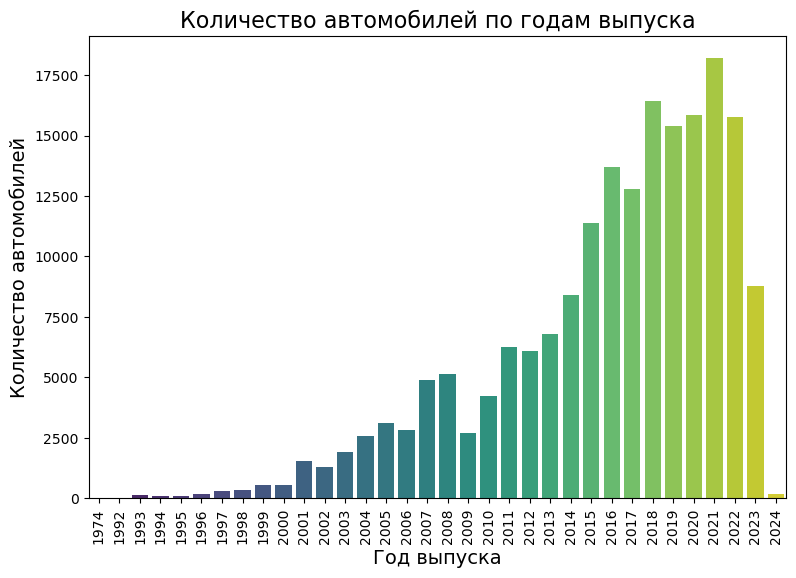

In [226]:
# Подсчёт количества автомобилей для каждого года, сортировка по убыванию
model_year_counts = data['model_year'].value_counts().sort_index(ascending=False)

# Увеличиваем размер графика
plt.figure(figsize=(9, 6))

# Построение графика с сортировкой по убыванию
sns.barplot(x=model_year_counts.index, y=model_year_counts.values, palette='viridis')

# Добавление подписей
plt.title('Количество автомобилей по годам выпуска', fontsize=16)
plt.xlabel('Год выпуска', fontsize=14)
plt.ylabel('Количество автомобилей', fontsize=14)

# Поворачиваем метки на оси X для удобства
plt.xticks(rotation=90)

# Отображение графика
plt.show()


Большинство автомобилей произведено с 2014 по 2023 год.

## Milage

/Users/vovatkachev/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


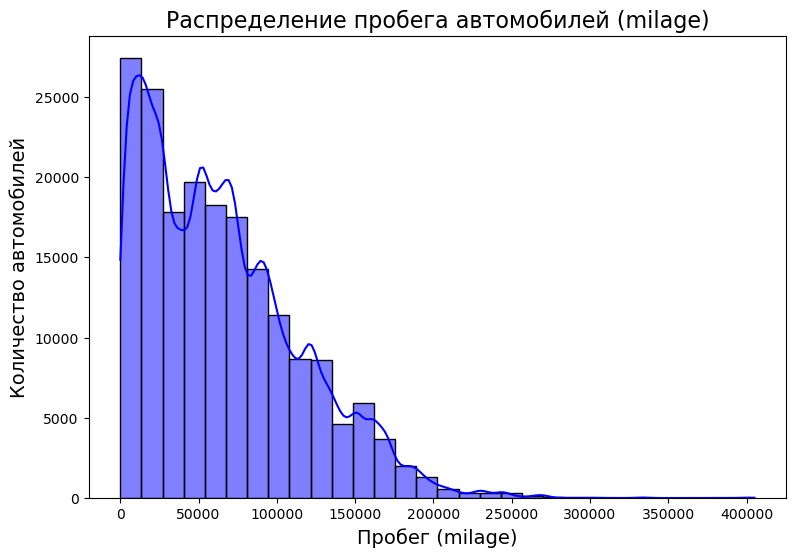

In [227]:
# Увеличиваем размер графика
plt.figure(figsize=(9, 6))

# Построение гистограммы для распределения пробега
sns.histplot(data['milage'], bins=30, kde=True, color='blue')

# Добавление подписей
plt.title('Распределение пробега автомобилей (milage)', fontsize=16)
plt.xlabel('Пробег (milage)', fontsize=14)
plt.ylabel('Количество автомобилей', fontsize=14)

# Отображение графика
plt.show()

In [228]:
data['milage'].describe()

count    188533.000000
mean      65705.295174
std       49798.158076
min         100.000000
25%       24115.000000
50%       57785.000000
75%       95400.000000
max      405000.000000
Name: milage, dtype: float64

Большая часть автомобилей имеет пробег до 60000.Почти все автомобили имеют пробег до 150000.

## Fuel_type

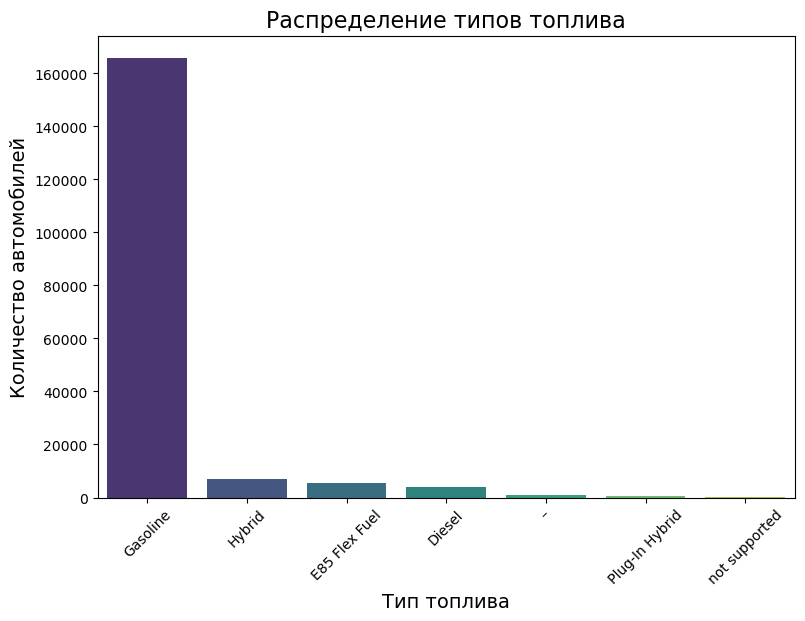

In [229]:
fuel_type_counts = data['fuel_type'].value_counts()

# Увеличиваем размер графика
plt.figure(figsize=(9, 6))

# Построение графика
sns.barplot(x=fuel_type_counts.index, y=fuel_type_counts.values, palette='viridis')

# Добавление подписей
plt.title('Распределение типов топлива', fontsize=16)
plt.xlabel('Тип топлива', fontsize=14)
plt.ylabel('Количество автомобилей', fontsize=14)

# Поворот меток на оси X
plt.xticks(rotation=45)

# Отображение графика
plt.show()


In [230]:
gasoline_percent = len(data[data['fuel_type'] == 'Gasoline']) / len(data)
print("Процент автомобилей на бензине:",gasoline_percent)

Процент автомобилей на бензине: 0.880164215283266


88 процентов всех автомобилей работают на бензине.  

## Engine

In [231]:
engine_counts = data['engine'].value_counts()
print(len(engine_counts))

1117


В нашей выборке 1117 различных видов двигателей.

In [232]:
print("Топ10 самых популярных двигателей:")
print(engine_counts[:10])

Топ10 самых популярных двигателей:
engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel             3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel             2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2841
2.0L I4 16V GDI DOHC Turbo                               2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            2451
340.0HP 3.0L V6 Cylinder Engine Gasoline Fuel            2436
490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2187
455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2138
425.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    2134
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    2084
Name: count, dtype: int64


In [233]:
print("Топ10 самых непопулярных двигателей:")
print(engine_counts[-10:])

Топ10 самых непопулярных двигателей:
engine
543.0HP 5.5L 12 Cylinder Engine Gasoline Fuel          2
250.0HP 2.7L V6 Cylinder Engine Gasoline Fuel          2
443.0HP 4.4L 8 Cylinder Engine Gasoline Fuel           1
70.0HP 1.0L 3 Cylinder Engine Gasoline Fuel            1
111.0HP Electric Motor Electric Fuel System            1
151.0HP 1.5L 4 Cylinder Engine Gas/Electric Hybrid     1
184.0HP 2.4L 4 Cylinder Engine Flex Fuel Capability    1
78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel            1
139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas    1
313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas    1
Name: count, dtype: int64


Возможно,лучше разбить признак engine на 5 признаков:
1. количество лошадиных сил
2. объём
3. количество цилиндров
4. тип двигателя
5. тип топлива

Но не во всех двигателях указаны все эти характеристики.

## Transmission

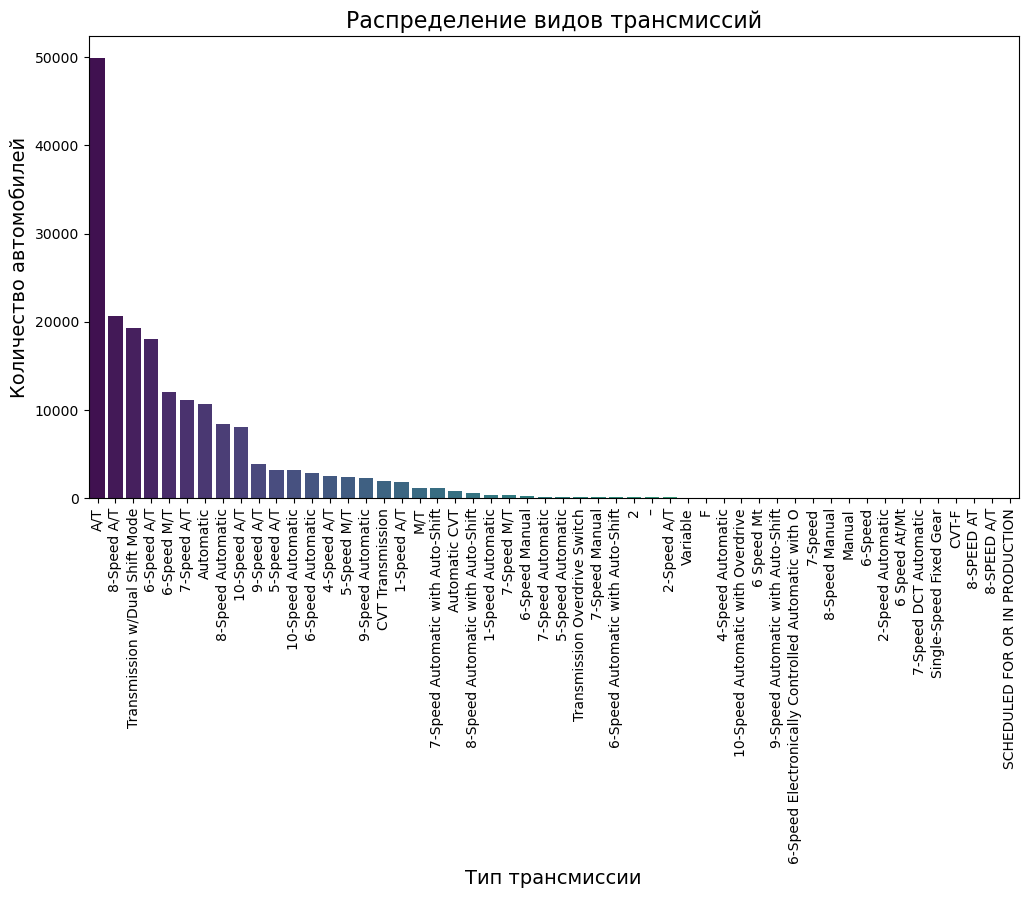

In [234]:
transmission_counts = data['transmission'].value_counts()

# Увеличиваем размер графика
plt.figure(figsize=(12, 6))

# Построение графика
sns.barplot(x=transmission_counts.index, y=transmission_counts.values, palette='viridis')

# Добавление подписей
plt.title('Распределение видов трансмиссий', fontsize=16)
plt.xlabel('Тип трансмиссии', fontsize=14)
plt.ylabel('Количество автомобилей', fontsize=14)

# Поворот меток на оси X
plt.xticks(rotation=90)

# Отображение графика
plt.show()

In [235]:
print("Топ10 популярных типов трансмиссий:")
print(transmission_counts[:10])

Топ10 популярных типов трансмиссий:
transmission
A/T                               49904
8-Speed A/T                       20645
Transmission w/Dual Shift Mode    19255
6-Speed A/T                       18044
6-Speed M/T                       11998
7-Speed A/T                       11124
Automatic                         10691
8-Speed Automatic                  8431
10-Speed A/T                       8044
9-Speed A/T                        3866
Name: count, dtype: int64


In [236]:
print("Топ10 непопулярных видов трансмиссий:")
print(transmission_counts[-10:])

Топ10 непопулярных видов трансмиссий:
transmission
Manual                            27
6-Speed                           27
2-Speed Automatic                 22
6 Speed At/Mt                     20
7-Speed DCT Automatic             18
Single-Speed Fixed Gear           16
CVT-F                             15
8-SPEED AT                        13
8-SPEED A/T                        7
SCHEDULED FOR OR IN PRODUCTION     6
Name: count, dtype: int64


## Ext_col

In [237]:
ext_col_counts = data['ext_col'].value_counts()
print("Количество различных цветов автомобиля:",len(ext_col_counts))
print()
print("Топ10 популярных цветов автомобиля:")
print(ext_col_counts[:10])

Количество различных цветов автомобиля: 319

Топ10 популярных цветов автомобиля:
ext_col
Black     48658
White     43815
Gray      25293
Silver    16995
Blue      14555
Red        9901
Green      2698
Gold       1668
Brown      1162
Orange     1139
Name: count, dtype: int64


## int_col

In [238]:
int_col_counts = data['int_col'].value_counts()
print("Количество различных цветов салона автомобиля:",len(int_col_counts))
print()
print("Топ10 популярных цветов салона автомобиля:")
print(int_col_counts[:10])

Количество различных цветов салона автомобиля: 156

Топ10 популярных цветов салона автомобиля:
int_col
Black        107674
Beige         24495
Gray          21204
Brown          5810
Red            5145
White          4743
–              4527
Jet Black      2398
Ebony          1833
Orange          932
Name: count, dtype: int64


## Accident

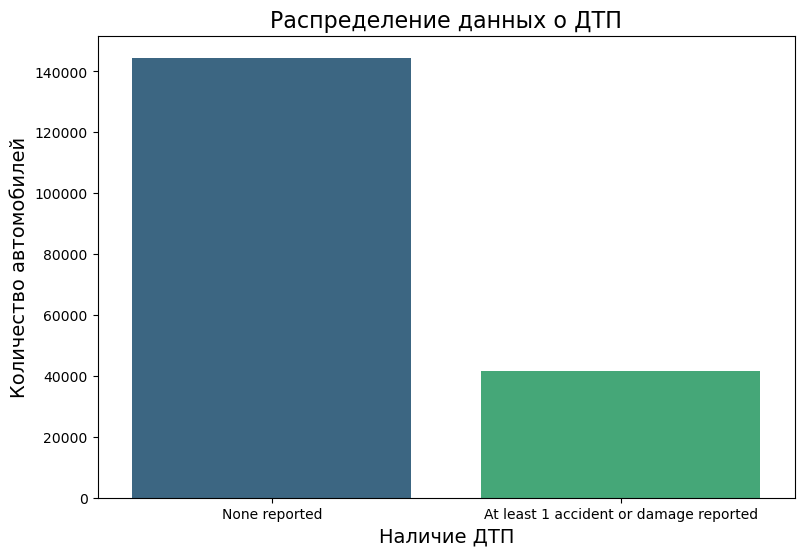

In [239]:
accident_counts = data['accident'].value_counts()

# Увеличиваем размер графика
plt.figure(figsize=(9, 6))

# Построение графика
sns.barplot(x=accident_counts.index, y=accident_counts.values, palette='viridis')

# Добавление подписей
plt.title('Распределение данных о ДТП', fontsize=16)
plt.xlabel('Наличие ДТП', fontsize=14)
plt.ylabel('Количество автомобилей', fontsize=14)

# Поворот меток на оси X
plt.xticks(rotation=0)

# Отображение графика
plt.show()


In [240]:
print(accident_counts)

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64


Количество автомобилей без зарегестрированных ДТП - 144515.Количество автомобили с ДТП - 41567.

## Clean_title

In [241]:
clean_title_count = data['clean_title'].value_counts()
print(clean_title_count)


clean_title
Yes    167114
Name: count, dtype: int64


В данном столбце присутствует только одно значение - YES.Заполнение пропущенных значений рассмотрим далее.

# Price

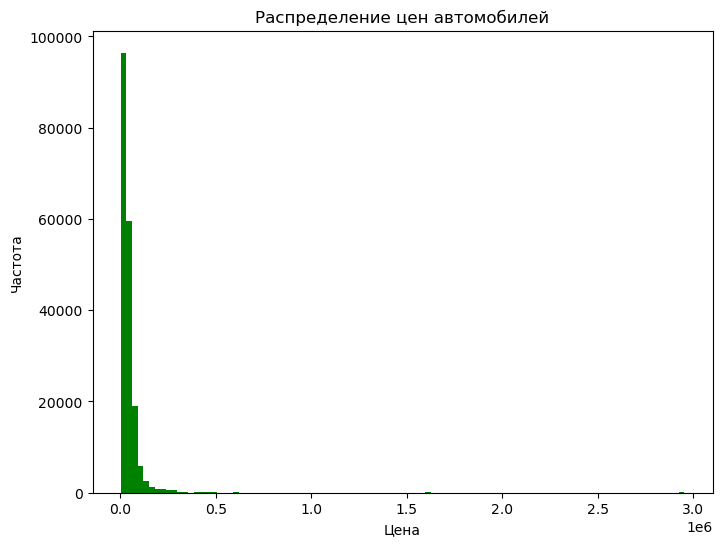

In [242]:
# Построение графика распределения цен автомобилей
plt.figure(figsize=(8, 6))
data['price'].hist(bins=100, color='green')
plt.title('Распределение цен автомобилей')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.grid(False)
plt.show()

# Data processing

In [243]:
# Посмотрим,сколько пропусков у нас в каждом признаке и какой процент от всех данных составляют пропуски
total_rows = len(data)
missing_counts = data.isnull().sum()
missing_percentage = (missing_counts / total_rows) * 100

missing_data = pd.DataFrame({
    'Feature': missing_counts.index,  # Название признаков
    'Missing Count': missing_counts.values,  # Количество пропусков
    'Missing Percentage': missing_percentage.values  # Процент пропусков
})

# Сортировка по убыванию количества пропусков
missing_data = missing_data.sort_values(by=['Missing Count', 'Missing Percentage'], ascending=False)
print(missing_data)

         Feature  Missing Count  Missing Percentage
10   clean_title          21419           11.360876
4      fuel_type           5083            2.696080
9       accident           2452            1.300568
0          brand              0            0.000000
1          model              0            0.000000
2     model_year              0            0.000000
3         milage              0            0.000000
5         engine              0            0.000000
6   transmission              0            0.000000
7        ext_col              0            0.000000
8        int_col              0            0.000000
11         price              0            0.000000


У нас пропуски в столбцах: clean_title(11%),fuel_type(2.7%) и accident(1.3%):
1. Пропуски в clean_title логичнее всего заполнить NO - то есть у автомобиля нет юридической чистоты,раз это не указано.
2. Пропущенные значения в fuel_type можем достать из столбца engine.
3. Пропуски в accident можно заполнить At least 1 accident or damage reported,раз не указано None reported,значит скорее всего были ДТП.

In [244]:
data['accident'] = data['accident'].fillna('At least 1 accident or damage reported')
data['clean_title'] = data['clean_title'].fillna('NO')

In [245]:
print("Количество различных видов топлива до заполнения пропусков",len(fuel_type_counts))
print(fuel_type_counts)

Количество различных видов топлива до заполнения пропусков 7
fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64


In [246]:
# Создадим функцию,которая в описании двигателя находит тип топлива
def findFuel(engine):
    mas = engine.split()
    for type in list(fuel_type_counts):
        if type in mas:
            return type
    return "unknown"

In [247]:
data['fuel_type'] = data.apply(
    lambda row: findFuel(row['engine']) if pd.isna(row['fuel_type']) else row['fuel_type'], axis=1
)

In [248]:
# Проверим,что заполнили все пропущенные значения
missing_counts = data.isna().sum().sum()
print(missing_counts)

0


Заполнили все пропуски в датасете.

In [249]:
# Масштабируем числовые признаки
scaler = StandardScaler()
scaler.fit_transform(data[numerical_columns])

array([[ 2.95784224, -1.55980788],
       [ 1.55718431, -2.4430515 ],
       [ 1.42627551, -2.4430515 ],
       ...,
       [-1.04532849,  0.91327427],
       [-1.04040861,  1.089923  ],
       [-0.12460926,  0.03003065]])

In [250]:
# Преобразуем тип категориальных признаков в category
for feature in categorical_columns:
    data[feature] = data[feature].astype('category')

In [251]:
# Разделим наши данные на тренировочную и тестовую выборку
X = data.drop('price',axis = 1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

# Model

In [252]:
params = {
    'loss_function' : 'RMSE',
    'eval_metric' : 'RMSE',
    'iterations' : 1000,
    'random_seed' : 42,
    'learning_rate' : 0.03,
    'l2_leaf_reg' : 3,
    'random_strength' : 1,
    'bagging_temperature' : 1,
    'leaf_estimation_method' : 'Newton',
    'one_hot_max_size' : 2

}

In [253]:
cv_data = cv(
    params = params,
    pool = Pool(X_train,label = y_train,cat_features = categorical_columns),
    fold_count = 6,
    shuffle = True,
    partition_random_seed=42,
    plot = True,
    verbose = False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/6]

bestTest = 67361.42729
bestIteration = 917

Training on fold [1/6]

bestTest = 68849.36492
bestIteration = 452

Training on fold [2/6]

bestTest = 63559.80198
bestIteration = 513

Training on fold [3/6]

bestTest = 81058.57708
bestIteration = 998

Training on fold [4/6]

bestTest = 85027.02647
bestIteration = 871

Training on fold [5/6]

bestTest = 76174.64453
bestIteration = 905



In [254]:
# Теперь обучим нашу модель на всей выборке и получим итоговые предскащания
model = CatBoostRegressor(**params)

# Обучение модели на тренировочной выборке
model.fit(X_train, y_train, cat_features=categorical_columns, verbose=False)

# Предсказания на тестовой выборке
predictions = model.predict(X_test)

In [255]:
# Вычисление RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)

# Вывод результата
print(f'RMSE: {rmse}')

RMSE: 68121.7320778295
